In [1]:
import requests
import lxml.html as lh
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

In [2]:
#url='https://www.hnd.bayern.de/pegel/regnitz/nuernberg-lederersteg-24225000/tabelle?methode=wasserstand&days=365'#Create a handle, page, to handle the contents of the website
#url='https://www.gkd.bayern.de/de/fluesse/abfluss/kelheim/nuernberg-lederersteg-24225000/messwerte/tabelle?zr=woche&addhr=hr_hw&beginn=01.01.1970&ende=27.04.2020'

url="https://www.gkd.bayern.de/de/fluesse/wasserstand/kelheim/nuernberg-lederersteg-24225000/messwerte/tabelle?zr=woche&addhr=hr_w_hw&beginn=28.04.1990&ende=16.06.2020"
# Lederersteg 288,80 m NN (DHHN12) 
url2="https://www.gkd.bayern.de/de/fluesse/wasserstand/regnitz/huettendorf-24201501/messwerte/tabelle?zr=woche&addhr=hr_w_hw&beginn=28.04.1990&ende=26.06.2020"
# Hüttendorf:273,72 m NN (DHHN12) 
page = requests.get(url)#Store the contents of the website under doc
doc = lh.fromstring(page.content)#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')

page2 = requests.get(url2)#Store the contents of the website under doc
doc2 = lh.fromstring(page2.content)#Parse data that are stored between <tr>..</tr> of HTML
tr_elements2 = doc2.xpath('//tr')

In [3]:
#Check the length of the first 12 rows
#[len(T) for T in tr_elements2[:12]]
#doc.xpath('//tr')
#tr_elements2[1][1].text_content()

NNDifferenz=(288.80-273.72)*100

In [4]:
#Lederersteg
tr_elements = doc.xpath('//tr')#Create empty list
col=[]
i=0#For each row, store each first element (header) and an empty list
for t in tr_elements[1]:
    i+=1
    name=t.text_content()
    print (i,name) #'%d:"%s"%'
    col.append((name,[]))
    
#Hüttendorf    
tr_elements2 = doc2.xpath('//tr')#Create empty list
col2=[]
i=0#For each row, store each first element (header) and an empty list
for t in tr_elements2[1]:
    i+=1
    name=t.text_content()
    print (i,name) #'%d:"%s"%'
    col2.append((name,[]))

1 Datum
2 Mittelwert [cm]
3 Maximum [cm]
4 Minimum [cm]
1 Datum
2 Mittelwert [cm]
3 Maximum [cm]
4 Minimum [cm]


In [5]:
#Since the first row is the header, data is stored on the second row onwards
#Lederersteg
for j in range(2,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 2, the //tr data is not from our table 
    if len(T)!=4:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1
        
#Hüttendorf        
for j in range(2,len(tr_elements2)):
    #T is our j'th row
    T=tr_elements2[j]
    
    #If row is not of size 2, the //tr data is not from our table 
    if len(T)!=4:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col2[i][1].append(data)
        #Increment i for the next column
        i+=1

In [6]:
#Lederersteg
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)
#Hüttendorf
Dict2={title:column for (title,column) in col2}
df2=pd.DataFrame(Dict2)

In [7]:
col2[1][0]

'Mittelwert [cm]'

In [8]:
#make datetime index
format = '%d.%m.%Y'
df['Datetime'] = pd.to_datetime(np.array(df[col[0][0]]).astype(str), format=format)
df = df.set_index(pd.DatetimeIndex(df['Datetime']))

#replace "," with "." in numbers
df[col[1][0]] = [x.replace(',', '.') for x in df[col[1][0]].astype(str)]
df[col[2][0]] = [x.replace(',', '.') for x in df[col[2][0]].astype(str)]
df[col[3][0]] = [x.replace(',', '.') for x in df[col[3][0]].astype(str)]

#replace "--" with "NaN" where Numbers are expected
df[col[1][0]] = [x.replace('--', 'NaN') for x in df[col[1][0]].astype(str)]
df[col[2][0]] = [x.replace('--', 'NaN') for x in df[col[2][0]].astype(str)]
df[col[3][0]] = [x.replace('--', 'NaN') for x in df[col[3][0]].astype(str)]

# make float numbers
df[col[1][0]] = df[col[1][0]].astype(float)
df[col[2][0]] = df[col[2][0]].astype(float)
df[col[3][0]] = df[col[3][0]].astype(float)

# smoothen the curve
df["mean_m"]=df[col[1][0]].rolling(30, min_periods=0,center=True).mean()


# Hüttendorf
format = '%d.%m.%Y'
df2['Datetime'] = pd.to_datetime(np.array(df2[col2[0][0]]).astype(str), format=format)
df2 = df2.set_index(pd.DatetimeIndex(df2['Datetime']))

df2[col2[1][0]] = [x.replace(',', '.') for x in df2[col2[1][0]].astype(str)]
df2[col2[2][0]] = [x.replace(',', '.') for x in df2[col2[2][0]].astype(str)]
df2[col2[3][0]] = [x.replace(',', '.') for x in df2[col2[3][0]].astype(str)]

df2[col2[1][0]] = [x.replace('--', 'NaN') for x in df2[col2[1][0]].astype(str)]
df2[col2[2][0]] = [x.replace('--', 'NaN') for x in df2[col2[2][0]].astype(str)]
df2[col2[3][0]] = [x.replace('--', 'NaN') for x in df2[col2[3][0]].astype(str)]


df2[col2[1][0]] = df2[col2[1][0]].astype(float)
df2[col2[2][0]] = df2[col2[2][0]].astype(float)
df2[col2[3][0]] = df2[col2[3][0]].astype(float)

df2["mean_m"]=df2[col2[1][0]].rolling(30, min_periods=0,center=True).mean()




df2.head()

,Datum,Mittelwert [cm],Maximum [cm],Minimum [cm],Datetime,mean_m
Datetime,,,,,,
2020-06-18,18.06.2020,216.0,221.0,211.0,2020-06-18,207.933333
2020-06-17,17.06.2020,211.0,224.0,192.0,2020-06-17,206.875000
2020-06-16,16.06.2020,236.0,241.0,224.0,2020-06-16,206.352941
2020-06-15,15.06.2020,236.0,251.0,224.0,2020-06-15,205.888889
2020-06-14,14.06.2020,244.0,297.0,191.0,2020-06-14,205.473684


In [9]:
#(288.80-273.72)*100
df1=df[[col[1][0],col[2][0],col[3][0]]]+288.8*100 #df (df1) höher als df2
#df1.head()
df3=df1.subtract(df2[[col[1][0],col[2][0],col[3][0]]]+273.72*100) #+NNDifferenz
df3["mean_m"]=df3[col2[1][0]].rolling(365, min_periods=0,center=True).mean()
df3.head()


,Mittelwert [cm],Maximum [cm],Minimum [cm],mean_m
Datetime,,,,
1990-04-28,1495.0,1493.0,1495.0,1495.366120
1990-04-29,1497.0,1494.0,1500.0,1495.347826
1990-04-30,1499.0,1497.0,1504.0,1495.302703
1990-05-01,1499.0,1498.0,1504.0,1495.209677
1990-05-02,1499.0,1499.0,1502.0,1495.128342


In [10]:
#df3["mean_m"]=df["Mittelwert [cm]"].groupby(df3.index.year).mean()
#df3.mean_m

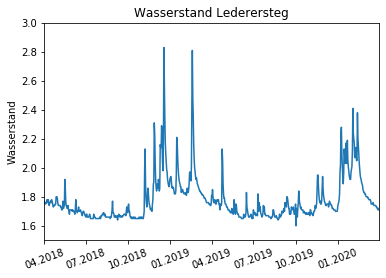

In [11]:
#from DateTime import DateTime
plt.title("Wasserstand Lederersteg")
plt.plot(df[col[1][0]]/100)
#plt.plot(df3["mean_m"]/100)
#plt.legend("NN Höhendifferenz 15.08 m",loc="best")
#plt.xlabel("Jahr")
plt.ylabel("Wasserstand")
plt.savefig("Welle_Stand.png",bbox_inches="tight")
#plt.xlim([datetime.date(2014, 1, 26), datetime.date(2014, 2, 1)])
plt.xlim(pd.Timestamp('2019-04-28'), pd.Timestamp('2020-04-27'))
plt.ylim([1.5,3])
dates = pd.date_range('2018-04-28', '2020-04-27', freq=pd.DateOffset(months=3))
plt.xticks(dates,labels=dates.strftime('%m.%Y'), rotation=20)
#plt.xtick()
plt.savefig("Welle_Stand_Lederersteg.png",bbox_inches="tight")

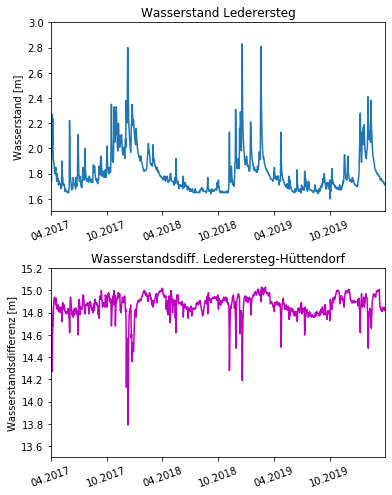

In [12]:
#from DateTime import DateTime
plt.figure(figsize=(6,8))

plt.subplot(2,1,1)
plt.title("Wasserstand Lederersteg")
plt.plot(df[col[1][0]]/100)
#plt.plot(df3["mean_m"]/100)
#plt.legend("NN Höhendifferenz 15.08 m",loc="best")
#plt.xlabel("Jahr")
plt.ylabel("Wasserstand [m]")
plt.savefig("Welle_Stand.png",bbox_inches="tight")
#plt.xlim([datetime.date(2014, 1, 26), datetime.date(2014, 2, 1)])
plt.xlim(pd.Timestamp('2017-04-28'), pd.Timestamp('2020-04-27'))
plt.ylim([1.5,3])
dates = pd.date_range('2017-04-28', '2020-04-27', freq=pd.DateOffset(months=6))
plt.xticks(dates,labels=dates.strftime('%m.%Y'), rotation=20)
#plt.xtick()
plt.subplots_adjust(hspace = 0.3 )
plt.subplot(2,1,2)

plt.title("Wasserstandsdiff. Lederersteg-Hüttendorf")
plt.plot(df3[col[1][0]]/100,'m')
#plt.plot(df3["mean_m"]/100)
#plt.legend("NN Höhendifferenz 15.08 m",loc="best")
#plt.xlabel("Jahr")
plt.ylabel("Wasserstandsdifferenz [m]")
plt.savefig("Welle_Stand.png",bbox_inches="tight")
#plt.xlim([datetime.date(2014, 1, 26), datetime.date(2014, 2, 1)])
plt.xlim(pd.Timestamp('2017-04-28'), pd.Timestamp('2020-04-27'))
plt.ylim([13.5,15.2])
dates = pd.date_range('2017-04-28', '2020-04-27', freq=pd.DateOffset(months=6))
plt.xticks(dates,labels=dates.strftime('%m.%Y'), rotation=20)
#plt.xtick()
plt.savefig("Welle_Stand.png",bbox_inches="tight")

In [13]:
pwd

'C:\\Users\\Maria\\OneDrive\\Dokumente\\Python Scripts'

In [14]:
def category(names, lower, upper):  
    name=[] 
    for i in range(len(df)):
        if lower<df[col[1][0]].iloc[i]<=upper  : 
            name.append(1)
        else:
            name.append(0)
    df[names] = name
    return df
#hüttendorf
def category2(names, lower, upper):  
    name=[] 
    for i in range(len(df2)):
        if lower<df2[col2[1][0]].iloc[i]<=upper  : 
            name.append(1)
        else:
            name.append(0)
    df2[names] = name
    return df2
#differenz
def category3(names, lower, upper):  
    name=[] 
    for i in range(len(df3)):
        if lower<df3[col2[1][0]].iloc[i]<=upper  : 
            name.append(1)
        else:
            name.append(0)
    df3[names] = name
    return df3

In [15]:
category('extr. low', 0, 150)
category('low', 150, 180)
category('medium', 180, 230)
category('high', 230, 300)
category('extr. high', 300, 1000)

category2('extr. low', 0, 150)
category2('low', 150, 180)
category2('medium', 180, 230)
category2('high', 230, 300)
category2('extr. high', 300, 1000)

category3('extr. low', 0, 1350)
category3('low', 1350, 1425)
category3('medium', 1425, 1480)
category3('high', 1480, 1500)
category3('extr. high', 1500, 10000)

,Mittelwert [cm],Maximum [cm],Minimum [cm],mean_m,extr. low,low,medium,high,extr. high
Datetime,,,,,,,,,
1990-04-28,1495.0,1493.0,1495.0,1495.366120,0,0,0,1,0
1990-04-29,1497.0,1494.0,1500.0,1495.347826,0,0,0,1,0
1990-04-30,1499.0,1497.0,1504.0,1495.302703,0,0,0,1,0
1990-05-01,1499.0,1498.0,1504.0,1495.209677,0,0,0,1,0
1990-05-02,1499.0,1499.0,1502.0,1495.128342,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
2020-06-14,1458.0,1485.0,1497.0,1486.686486,0,0,1,0,0
2020-06-15,1471.0,1467.0,1465.0,1486.663043,0,0,1,0,0
2020-06-16,1474.0,1478.0,1479.0,1486.622951,0,0,1,0,0


In [16]:
exhigh=df.groupby(df['Datetime'].dt.year).sum()["extr. high"]
high=df.groupby(df['Datetime'].dt.year).sum()["high"]
medium=df.groupby(df['Datetime'].dt.year).sum()["medium"]
low=df.groupby(df['Datetime'].dt.year).sum()["low"]
exlow=df.groupby(df['Datetime'].dt.year).sum()["extr. low"]

exhigh_month=df.groupby(df['Datetime'].dt.month).sum()["extr. high"]/(50+1/3)
high_month=df.groupby(df['Datetime'].dt.month).sum()["high"]/(50+1/3)
medium_month=df.groupby(df['Datetime'].dt.month).sum()["medium"]/(50+1/3)
low_month=df.groupby(df['Datetime'].dt.month).sum()["low"]/(50+1/3)
exlow_month=df.groupby(df['Datetime'].dt.month).sum()["extr. low"]/(50+1/3)


exhigh2=df2.groupby(df2['Datetime'].dt.year).sum()["extr. high"]
high2=df2.groupby(df2['Datetime'].dt.year).sum()["high"]
medium2=df2.groupby(df2['Datetime'].dt.year).sum()["medium"]
low2=df2.groupby(df2['Datetime'].dt.year).sum()["low"]
exlow2=df2.groupby(df2['Datetime'].dt.year).sum()["extr. low"]

exhigh_month2=df2.groupby(df2['Datetime'].dt.month).sum()["extr. high"]/(50+1/3)
high_month2=df2.groupby(df2['Datetime'].dt.month).sum()["high"]/(50+1/3)
medium_month2=df2.groupby(df2['Datetime'].dt.month).sum()["medium"]/(50+1/3)
low_month2=df2.groupby(df2['Datetime'].dt.month).sum()["low"]/(50+1/3)
exlow_month2=df2.groupby(df2['Datetime'].dt.month).sum()["extr. low"]/(50+1/3)


#Differenz
exhigh3=df3.groupby(df3.index.year).sum()["extr. high"]
high3=df3.groupby(df3.index.year).sum()["high"]
medium3=df3.groupby(df3.index.year).sum()["medium"]
low3=df3.groupby(df3.index.year).sum()["low"]
exlow3=df3.groupby(df3.index.year).sum()["extr. low"]

exhigh_month3=df3.groupby(df3.index.month).sum()["extr. high"]
high_month3=df3.groupby(df3.index.month).sum()["high"]/(50+1/3)
medium_month3=df3.groupby(df3.index.month).sum()["medium"]/(50+1/3)
low_month3=df3.groupby(df3.index.month).sum()["low"]/(50+1/3)
exlow_month3=df3.groupby(df3.index.month).sum()["extr. low"]/(50+1/3)

In [17]:
#exhigh_trend=df["extr. high"].rolling(365).sum().rolling(365).mean()
exhigh_trend=exhigh.rolling(10,center=True,min_periods=0).mean()
high_trend=high.rolling(10,center=True,min_periods=0).mean()
medium_trend=medium.rolling(10,center=True,min_periods=0).mean()
low_trend=low.rolling(10,center=True,min_periods=0).mean()
exlow_trend=exlow.rolling(10,center=True,min_periods=0).mean()


exhigh_trend2=exhigh2.rolling(10,center=True,min_periods=0).mean()
high_trend2=high2.rolling(10,center=True,min_periods=0).mean()
medium_trend2=medium2.rolling(10,center=True,min_periods=0).mean()
low_trend2=low2.rolling(10,center=True,min_periods=0).mean()
exlow_trend2=exlow2.rolling(10,center=True,min_periods=0).mean()


Text(0, 0.5, 'Häufigkeit in Tagen')

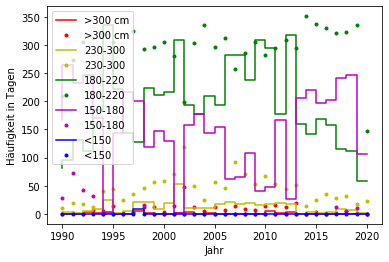

In [18]:
plt.plot(exhigh,"r-",ds="steps",label=">300 cm")
plt.plot(exhigh2,"r.",ds="steps",label=">300 cm")

plt.plot(high,"y-",ds="steps",label="230-300")
plt.plot(high2,"y.",ds="steps",label="230-300")

plt.plot(medium,"g-",ds="steps",label="180-220")
plt.plot(medium2,"g.",ds="steps",label="180-220")

plt.plot(low,"m-",ds="steps",label="150-180")
plt.plot(low2,"m.",ds="steps",label="150-180")

plt.plot(exlow,"b-",ds="steps",label="<150")
plt.plot(exlow2,"b.",ds="steps",label="<150")

#plt.plot(exhigh_trend,"r.")
#plt.plot(high_trend,"y.")
#plt.plot(medium_trend,"g.")
#plt.plot(low_trend,"m.")
#plt.plot(exlow_trend,"b.")


plt.legend(loc="upper left")
plt.xlabel("Jahr")
plt.ylabel("Häufigkeit in Tagen")

(0, 30)

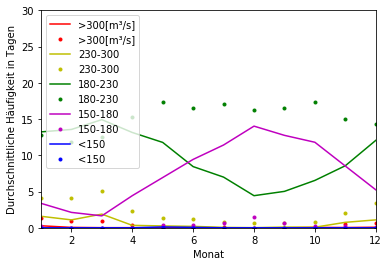

In [19]:
plt.figure(figsize=(6,4))
 #   plt.subplots(1, 2, sharex='col')
#plt.subplot(2,1,1)
plt.title("")
plt.plot(exhigh_month,"r-",label=">300[m³/s]")
plt.plot(exhigh_month2,"r.",label=">300[m³/s]")

plt.plot(high_month,"y-",label="230-300")
plt.plot(high_month2,"y.",label="230-300")

plt.plot(medium_month,"g-",label="180-230")
plt.plot(medium_month2,"g.",label="180-230")

plt.plot(low_month,"m-",label="150-180")
plt.plot(low_month2,"m.",label="150-180")

plt.plot(exlow_month,"b-",label="<150")
plt.plot(exlow_month2,"b.",label="<150")

#plt.plot(exhigh_trend,"r.")
#plt.plot(high_trend,"y.")
#plt.plot(medium_trend,"g.")
#plt.plot(low_trend,"m.")
#plt.plot(exlow_trend,"b.")
plt.legend(loc="best")
plt.xlabel("Monat")
plt.ylabel("Durchschnittliche Häufigkeit in Tagen")
plt.xlim([1,12])
plt.ylim([0,30])


Text(0, 0.5, 'Durchschnittliche Häufigkeit in Tagen')

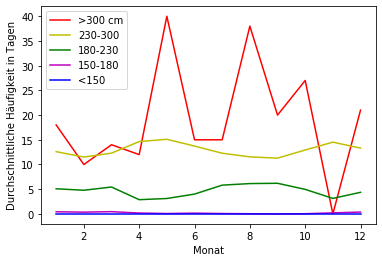

In [20]:
plt.figure(figsize=(6,4))
 #   plt.subplots(1, 2, sharex='col')
#plt.subplot(2,1,1)
plt.title("")
plt.plot(exhigh_month3,"r-",label=">300 cm")
plt.plot(high_month3,"y-",label="230-300")
plt.plot(medium_month3,"g-",label="180-230")
plt.plot(low_month3,"m-",label="150-180")
plt.plot(exlow_month3,"b-",label="<150")

#plt.plot(exhigh_trend,"r.")
#plt.plot(high_trend,"y.")
#plt.plot(medium_trend,"g.")
#plt.plot(low_trend,"m.")
#plt.plot(exlow_trend,"b.")
plt.legend(loc="best")
plt.xlabel("Monat")
plt.ylabel("Durchschnittliche Häufigkeit in Tagen")
#plt.xlim([1,12])
#plt.ylim([0,30])

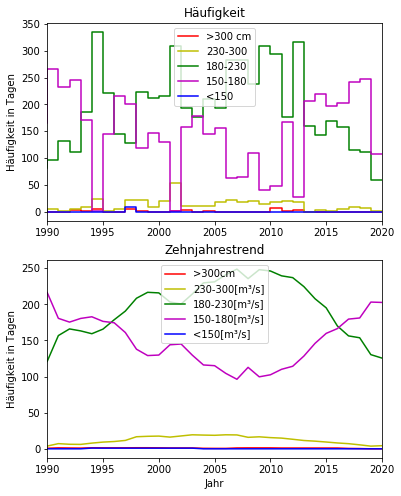

In [21]:
plt.figure(figsize=(6,8))
 #   plt.subplots(1, 2, sharex='col')
plt.subplot(2,1,1)
plt.title("Häufigkeit")
plt.plot(exhigh,"r-",ds="steps",label=">300 cm")
plt.plot(high,"y-",ds="steps",label="230-300")
plt.plot(medium,"g-",ds="steps",label="180-230")
plt.plot(low,"m-",ds="steps",label="150-180")
plt.plot(exlow,"b-",ds="steps",label="<150")
plt.legend(loc="best")
plt.xlim([1990,2020])

#plt.xlabel("Jahr")
plt.ylabel("Häufigkeit in Tagen")
plt.subplot(2,1,2)
plt.title("Zehnjahrestrend")

plt.plot(exhigh_trend,"r-",label=">300cm")
plt.plot(high_trend,"y-",label="230-300[m³/s]")
plt.plot(medium_trend,"g-",label="180-230[m³/s]")
plt.plot(low_trend,"m-",label="150-180[m³/s]")
plt.plot(exlow_trend,"b-",label="<150[m³/s]")
plt.legend(loc="best")
plt.xlim([1990,2020])

plt.xlabel("Jahr")
plt.ylabel("Häufigkeit in Tagen")
plt.savefig("Welle_Stand.png",bbox_inches="tight")


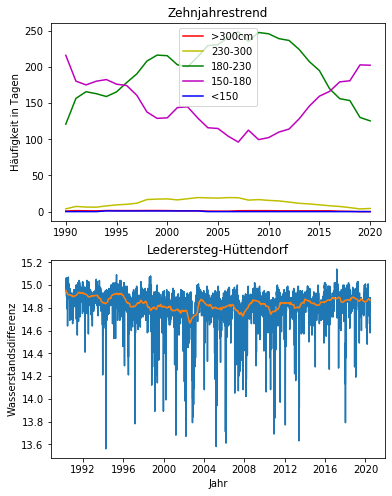

In [22]:
plt.figure(figsize=(6,8))
 #   plt.subplots(1, 2, sharex='col')
plt.subplot(2,1,1)
plt.title("Zehnjahrestrend")

plt.plot(exhigh_trend,"r-",label=">300cm")
plt.plot(high_trend,"y-",label="230-300")
plt.plot(medium_trend,"g-",label="180-230")
plt.plot(low_trend,"m-",label="150-180")
plt.plot(exlow_trend,"b-",label="<150")
#plt.legend(loc="upper left")
#plt.xlim([1970,2020])

#plt.xlabel("Jahr")
plt.ylabel("Häufigkeit in Tagen")
plt.legend(loc="best")
#plt.xlim([1970,2020])


plt.subplot(2,1,2)

plt.title("Lederersteg-Hüttendorf")
plt.plot(df3[col[1][0]]/100)
plt.plot(df3["mean_m"]/100)
#plt.legend(loc="best")
plt.xlabel("Jahr")
plt.ylabel("Wasserstandsdifferenz")
#plt.xlim([1970,2020])

plt.savefig("Welle_Stand.png",bbox_inches="tight")
